# 2 Use pretrained BERT for sentiment analysis

For the predictive model I use pretrained bidirectional transformer [BERT](https://huggingface.co/transformers/model_doc/bert.html).  It is a bidirectional transformer pretrained using a combination of masked language modeling objective and next sentence prediction on a large corpus comprising the Toronto Book Corpus and Wikipedia. This method is found to be one of the best for text classification and it is especially suitable for the project due to relatively low training effort needed for fine tuning of the already pretrained neural network.

In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures
from sklearn import metrics

%matplotlib inline
sns.set(font_scale=2)
plt.style.use("seaborn-white")

In [2]:
model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                        num_labels=5)
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


The random number seed for shuffling the training set should be used for maintaining shuffling in the case of Python runtime not keeping it's state between epochs (e.g. [Google Colab](https://colab.research.google.com)):

In [3]:
seed_batching = 123

In [4]:
model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  109482240 
_________________________________________________________________
dropout_37 (Dropout)         multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  3845      
Total params: 109,486,085
Trainable params: 109,486,085
Non-trainable params: 0
_________________________________________________________________


## 2.1 Creating of Training and Validation sets 

Loading clean and deduplicated dataset:

In [5]:
df_dedup = pd.read_csv("./ReviewsDedupLowNT.csv.zip",
                       compression="zip", 
                       keep_default_na=False,
                       index_col=0)

Transform review score to 0-based: from 1-5 stars to 0-4 label and rename column for clarity:

In [6]:
df_dedup["Score"] = df_dedup["Score"] - 1
df_dedup.rename(columns={"Score": "Label"}, inplace=True)
df_dedup.tail(5)

,Text,Summary,Label,HelpfulnessNumerator,HelpfulnessDenominator
394998,these are sooooooooooooooooooooooooo delicious...,"yummy. yummy, yummy!",4,0,3
394999,this is a for the price of review because p...,pure chocolate mallomars cookies,3,0,0
395000,this would be a great coffee drink to grab out...,soso espresso style coffee drink,2,1,2
395001,"earths best infant formula soy iron,ounce is a...",earths best soy baby formula,4,0,0
395002,taste. i was expecting it to taste pretty clos...,ehh okay i guess.,1,1,1


The dataset is splitted into *train* (80% samples) and *test* (20%) sets:

In [7]:
df_train = df_dedup.sample(frac=0.8, random_state=123)
df_test = df_dedup.drop(df_train.index)

At the first step a model predicting review score based on the review text will be created.
For training of the BERT model the dataset samples should be converted to the *InputExample* objects, containing

- *guid* - unique id for the example (not used)
- *text_a* (string) - the untokenized text of the first sequence
- *text_b* (optional, string) - the untokenized text of the second sequence (not used)
- label (optional, int) - The label of the example

and assembled to the TensorFlow datasets *train_data* and *validation_data*:

In [8]:
def convert_data_to_examples(df_input, data_column, label_column):
    input_examples = df_input.apply(lambda x:
                                    InputExample(guid=None,
                                                 text_a=x[data_column],
                                                 text_b=None,
                                                 label=x[label_column]),
                                    axis=1)
    return input_examples


def convert_examples_to_tf_dataset(examples, tokenizer, max_length=128):
    features = []
    for e in examples:
        input_dict = tokenizer.encode_plus(
            e.text_a,
            add_special_tokens=True,  # Adds [CLS] and [SEP].
            max_length=max_length,
            return_token_type_ids=True,
            return_attention_mask=True,
            padding="max_length",
            truncation=True)
        input_ids, token_type_ids, attention_mask = (
            input_dict["input_ids"], input_dict["token_type_ids"],
            input_dict['attention_mask'])
        features.append(InputFeatures(
            input_ids=input_ids, attention_mask=attention_mask,
            token_type_ids=token_type_ids, label=e.label))

    def gen():
        for f in features:
            yield ({
                "input_ids": f.input_ids,
                "attention_mask": f.attention_mask,
                "token_type_ids": f.token_type_ids, },
                f.label, )
    return tf.data.Dataset.from_generator(
        gen, ({
            "input_ids": tf.int32,
            "attention_mask": tf.int32,
            "token_type_ids": tf.int32},
            tf.int64),
        ({
            "input_ids": tf.TensorShape([None]),
            "attention_mask": tf.TensorShape([None]),
            "token_type_ids": tf.TensorShape([None]), },
            tf.TensorShape([]), ), )

In [9]:
train_input_examples = convert_data_to_examples(
    df_train, "Text", "Label") 
validation_input_examples = convert_data_to_examples(
    df_test, "Text", "Label")

train_data = convert_examples_to_tf_dataset(
    list(train_input_examples), tokenizer)
train_data = train_data.shuffle(
    buffer_size=1000, seed=seed_batching).batch(32)

validation_data = convert_examples_to_tf_dataset(
    list(validation_input_examples), tokenizer)
validation_data = validation_data.batch(32)

## 2.2 Treating sample imbalance

The classes in our dataset are highly imbalanced. Rating 5 stars (class 4) is over 60 percent of all examples with the other classes hovering around 10 percent. In order to mitigate the impact of an unbalanced training set the [*SparseCategoricalFocalLoss*](https://focal-loss.readthedocs.io/en/latest/generated/focal_loss.SparseCategoricalFocalLoss.html#focal_loss.SparseCategoricalFocalLoss) loss function is used. This function generalizes multiclass softmax cross-entropy by introducing a hyperparameter called the focusing parameter that allows hard-to-classify examples to be penalized more heavily relative to easy-to-classify examples.

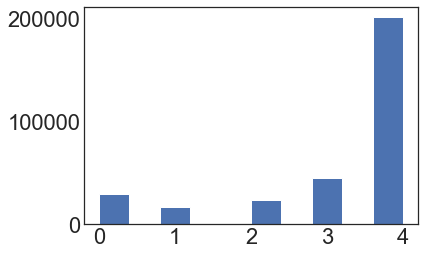

In [10]:
plt.hist(df_train["Label"]);

In [11]:
%run SparseCategoricalFocalLoss.py

<Figure size 432x288 with 0 Axes>

For the proper use of the *SparseCategoricalFocalLoss* loss function the *weights*, or classes distribution in the training set should be calculated:

In [12]:
num_classes = df_train["Label"].nunique()
classes_dist = []
n_of_class = df_train.groupby("Label")
for i in range(num_classes):
    classes_dist.append(len(n_of_class.groups[i])/len(df_train))
weights = tf.convert_to_tensor(classes_dist, dtype=tf.float32)

## 2.3 Training the model
The actual model has been trained on the [Google Colab](https://colab.research.google.com) free runtime. In order to feed the model with different training sets across the epochs *seed_batching* random seed should be changed. The variation of *learning_rate* parameter between 1e-5 and 4e-5 as well as *gamma* power from 1 to 4 did not affected validation accuracy significantly. The *amazon_my_trained_FL_G_k7e12ac78L03vac75VL04g2lr4* model was trained within 12 epochs, 11 epochs with 2000 steps and the last epoch with 7000 steps. The training step time for the given batch size was about 400 ms for P100 GPU and 800 ms for T4 GPU in full precision mode. The mixed precision mode give 400 ms per step on T4 GPU. The validation set accuracy along the epochs is slightly above 75%.

In [13]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(
        learning_rate=2e-5, epsilon=1e-08, clipnorm=1.0),
    loss=SparseCategoricalFocalLoss(
        gamma=2, class_weight=weights, from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy('accuracy')])

In [15]:
#model.fit(train_data, epochs=1, steps_per_epoch=10, validation_data=validation_data)

In [ ]:
#model.load_weights("./amazon_my_trained_FL_G_e3x3vac77")

Output of the actual training process at Google Colab:

The similarity of train and validation loss shows absence of overfitting.

## 2.4 Outlook

The model accuracy can be enhanced following ways:

- Training on cloud, making the model possible to see all the training examples during each epoch in reasonable time.
- Use human-assisted filtering, namely *HelpfulnessNumerator* and	*HelpfulnessDenominator* dataset columns, constructing DNN classifier using last BERT layer (of size 768), *HelpfulnessNumerator* and	*HelpfulnessDenominator* as an input.